![imaging1/4](https://img.shields.io/badge/imaging1/4-lightgrey)
[![Jupyter Notebook](https://img.shields.io/badge/Source%20on%20GitHub-orange)](https://github.com/laminlabs/lamin-usecases/blob/main/docs/imaging.ipynb)

# Imaging

Here, you will learn how to structure, featurize, and make large imaging collection queryable for large-scale machine learning:

1. Load and annotate a {class}`~lamindb.Collection` of microscopy images (![imaging/6](https://img.shields.io/badge/imaging1/6-lightgrey))
2. Generate single-cell images ([![imaging2/6](https://img.shields.io/badge/imaging2/6-lightgrey)](/imaging2))
3. Featurize single-cell images ([![imaging3/6](https://img.shields.io/badge/imaging3/6-lightgrey)](/imaging3))
4. Train model to identify autophagy positive cells ([![imaging4/6](https://img.shields.io/badge/imaging4/6-lightgrey)](/imaging4))


```{toctree}
:maxdepth: 1
:hidden:

imaging2
imaging3
imaging4
```

First, we will load and annotate a collection of microscopy images in TIFF format that [was previously uploaded](https://lamin.ai/scportrait/examples/transform/asoq6WyPequ8?).

The images used here were acquired as part of a [study](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.biorxiv.org/content/10.1101/2023.06.01.542416v1&ved=2ahUKEwj3m56hs52LAxWxRfEDHQZwKZ8QFnoECBIQAQ&usg=AOvVaw04HsGDIPcIPr1ldblXuh0Z)) on autophagy, a cellular process during which cells recycle their components in autophagosomes.

The study tracked genetic determinants of autophagy through fluorescence microscopy of human U2OS cells.
Cells were engineered to express two markers: the fluorescent autophagosome marker `mCherry-LC3B` and the fluorescent plasma membrane label `LckLip-mNeon`.
Autophagy was induced using `Torin-1`, and cells were counterstained for DNA visualization.

These three structures are visualized in three separate image channels:

| Channel | Imaged Structure   |
|---------|--------------------|
| 1       | DNA                |
| 2       | Autophagosomes     |
| 3       | Plasma Membrane    |

In [1]:
# TODO local instance

In [12]:
import lamindb as ln
import bionty as bt
from tifffile import imread
import matplotlib.pyplot as plt

ln.track()

→ loaded Transform('VBrMixbCU41a0000'), re-started Run('u6S41BHO...') at 2025-02-23 15:13:10 UTC
→ notebook imports: bionty==1.1.0 lamindb==1.1.0 matplotlib==3.10.0 pandas==2.2.3 tifffile==2025.1.10


All image metadata is stored in an already ingested `.csv` file.

In [ ]:
metadata_files = ln.Artifact.get(key = "input_data_imaging_usecase/metadata_files.csv").load()
metadata_files.head(2)

• adding artifact ids [267] as inputs for run 108, adding parent transform 65


,image_path,genotype,stimulation,cell_line,cell_line_clone,channel,FOV,magnification,microscope,imaged structure,resolution
0,input_data_imaging_usecase/images/Timepoint001...,WT,14h Torin-1,U2OS,U2OS lcklip-mNeon mCherryLC3B clone 1,Alexa488,FOV1,20X,Opera Phenix,LckLip-mNeon,0.597976
1,input_data_imaging_usecase/images/Timepoint001...,WT,14h Torin-1,U2OS,U2OS lcklip-mNeon mCherryLC3B clone 1,Alexa488,FOV2,20X,Opera Phenix,LckLip-mNeon,0.597976


In [ ]:
metadata_files.apply(lambda col: col.unique())

image_path          [input_data_imaging_usecase/images/Timepoint00...
genotype                                                 [WT, EI24KO]
stimulation                                  [14h Torin-1, untreated]
cell_line                                                      [U2OS]
cell_line_clone     [U2OS lcklip-mNeon mCherryLC3B clone 1, U2OS l...
channel                                     [Alexa488, DAPI, mCherry]
FOV                                                      [FOV1, FOV2]
magnification                                                   [20X]
microscope                                             [Opera Phenix]
imaged structure                    [LckLip-mNeon, DNA, mCherry-LC3B]
resolution                                              [0.597976081]
dtype: object

All images are of the same cell line (U2OS), which have been imaged on an Opera Phenix microscope at 20X magnification.
To induce autophagy, the cells have either been treated with `Torin-1`, a small molecule that mimics starvation, for 14 hours, or left untreated as a control.

To visualize the process of autophagosome formation, the U2OS cells have been genetically engineered to express fluorescently tagged proteins.
`LC3B` is a  marker of autophagosomes, allowing us to visualize their formation in the mCherry channel.
`LckLip` is a membrane-targeted fluorescent protein, which helps outline the cellular boundaries of individual cells in the `Alexa488` channel.
Furthermore, the cells’ DNA was stained using `Hoechst`, which we can visualize in the `DAPI` channel to identify the nuclei of individual cells.

In addition to expressing fluorescently tagged proteins, some of the cells have had the `EI24` gene knocked out, leading to two different genotypes: WT (wild-type) cells and `EI24KO` (knockout) cells.
For each genotype, two different clonal cell lines were analyzed, with multiple fields of view (FOVs) captured per condition.

To enable queries on our images, we annotate them with the corresponding metadata.

In [ ]:
autophagy_imaging_schema = ln.Schema(
    name="Autophagy imaging schema",
    features=[
        ln.Feature(name="genotype", dtype=ln.ULabel.name).save(),
        ln.Feature(name="stimulation", dtype=ln.ULabel.name).save(),
        ln.Feature(name="cell_line", dtype=bt.CellLine.name).save(),
        ln.Feature(
            name="cell_line_clone", dtype=ln.ULabel.name
        ).save(),
        ln.Feature(name="channel", dtype=ln.ULabel.name).save(),
        ln.Feature(name="FOV", dtype=ln.ULabel.name).save(),
        ln.Feature(name="magnification", dtype=ln.ULabel.name).save(),
        ln.Feature(name="microscope", dtype=ln.ULabel.name).save(),
        ln.Feature(name="imaged structure", dtype=ln.ULabel.name).save(),
        ln.Feature(name="resolution", dtype=float, description = "conversion factor for px to µm").save()
    ],
    coerce_dtype=True
).save()

→ returning existing Feature record with same name: 'genotype'
→ returning existing Feature record with same name: 'stimulation'
→ returning existing Feature record with same name: 'cell_line'
→ returning existing Feature record with same name: 'cell_line_clone'
→ returning existing Feature record with same name: 'channel'
→ returning existing Feature record with same name: 'FOV'
→ returning existing Feature record with same name: 'magnification'
→ returning existing Feature record with same name: 'microscope'
→ returning existing Feature record with same name: 'imaged structure'
→ returning existing Feature record with same name: 'resolution'


In [65]:
curator = ln.curators.DataFrameCurator(metadata_files, autophagy_imaging_schema)
curator.validate()

✓ "genotype" is validated against ULabel.name
✓ "stimulation" is validated against ULabel.name
✓ "cell_line" is validated against CellLine.name
✓ "cell_line_clone" is validated against ULabel.name
✓ "channel" is validated against ULabel.name
✓ "FOV" is validated against ULabel.name
✓ "magnification" is validated against ULabel.name
✓ "microscope" is validated against ULabel.name
✓ "imaged structure" is validated against ULabel.name


Now lets add all of our images to our lamindb instance in a loop already annotating all relevant metadata.

In [ ]:
# Create study feature and associated label
ln.Feature(name="study", dtype=ln.ULabel).save()
ln.ULabel(name="autophagy imaging").save()

# loop through all artifacts and add feature values
# TODO discuss whether we should not create new Artifacts here but rather filter for the existing ones
artifacts = []
for idx, row in metadata_files.iterrows():
    artifact = ln.Artifact(row["image_path"], 
                           description="raw image of U2OS cells stained for autophagy markers",
                           )
    artifact.save()
    artifact.cell_lines.add(bt.CellLine.filter(name = row.cell_line).one())

    artifact.features.add_values(
        {
            "genotype": row.genotype,
            "stimulation": row.stimulation,
            "cell_line_clone": row.cell_line_clone,
            "channel": row.channel,
            "imaged structure": row["imaged structure"],
            "study": "autophagy imaging",
            "artifact type": "input images",
            "FOV": row.FOV, 
            "magnification": row.magnification,
            "microscope": row.microscope,
            "resolution": row.resolution,
        }
    )

    artifacts.append(artifact)  

→ found artifact with same hash: Artifact(uid='D78mnvc00leUXchR0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_Alexa488_zstack001_r003_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='0aoXxT857VvKAGo9UQo-8g', space_id=1, storage_id=1, run_id=107, created_by_id=4, created_at=2025-02-05 12:31:39 UTC); to track this artifact as an input, use: ln.Artifact.get()
→ found artifact with same hash: Artifact(uid='M9K9SMqq8KzcVyQ60000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_Alexa488_zstack001_r004_c007.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='Mm-DsaVdkMbTreUW_ipQBQ', space_id=1, storage_id=1, run_id=107, created_by_id=4, created_at=2025-02-05 12:31:46 UTC); to track this artifact as an input, use: ln.Artifact.get()
→ found artifact with same hash: Artifact(uid='cWztVN7NE7nRxbzi0000'

In [69]:
artifacts[0].describe()

Artifact .tif
├── General
│   ├── .uid = 'D78mnvc00leUXchR0000'
│   ├── .key = 'input_data_imaging_usecase/images/Timepoint001_Row01_Well01_Alexa488_zstack001_r003_c005.tif'
│   ├── .size = 2333056
│   ├── .hash = '0aoXxT857VvKAGo9UQo-8g'
│   ├── .path = s3://lamin-eu-central-1/r7YUayXjktSb/.lamindb/D78mnvc00leUXchR0000.tif
│   ├── .created_by = sophiamaedler
│   ├── .created_at = 2025-02-05 13:31:39
│   └── .transform = 'Imaging'
├── Linked features
│   └── FOV                         cat[ULabel.name]           FOV1                                     
│       artefact type               cat[ULabel]                input images                             
│       artifact type               cat[ULabel]                input images                             
│       cell_line_clone             cat[ULabel.name]           U2OS lcklip-mNeon mCherryLC3B clone 1    
│       channel                     cat[ULabel.name]           Alexa488                                 
│       genotype                    cat[ULabel.name]           WT                                       
│       imaged structure            cat[ULabel.name]           LckLip-mNeon                             
│       magnification               cat[ULabel.name]           20X                                      
│       microscope                  cat[ULabel.name]           Opera Phenix                             
│       stimulation                 cat[ULabel.name]           14h Torin-1                              
│       study                       cat[ULabel]                autophagy imaging                        
│       resolution                  float                      0.597976081                              
└── Labels
    └── .cell_lines                 bionty.CellLine            U2OS                                     
        .ulabels                    ULabel                     FOV1, 14h Torin-1, 20X, autophagy imagin…

In addition, we create a collection to hold all `Artifacts` that belong to this specific imaging study.

In [71]:
collection = ln.Collection(
    artifacts,
    key="Annotated autophagy imaging raw images",
    description="annotated microscopy images of cells stained for autophagy markers",
)
collection.save()  

! returning existing collection with same hash: Collection(uid='wg5764wYQEk1YcFE0000', is_latest=True, key='Annotated autophagy imaging raw images', description='annotated microscopy images of cells stained for autophagy markers', hash='6L85RD5Q83sQ7ZwaNOIMNw', created_by_id=4, space_id=1, run_id=108, created_at=2025-02-05 12:33:23 UTC); if you intended to query to track this collection as an input, use: ln.Collection.get()


Collection(uid='wg5764wYQEk1YcFE0000', is_latest=True, key='Annotated autophagy imaging raw images', description='annotated microscopy images of cells stained for autophagy markers', hash='6L85RD5Q83sQ7ZwaNOIMNw', created_by_id=4, space_id=1, run_id=108, created_at=2025-02-05 12:33:23 UTC)

Let's look at some example images where we match images from the same clone, stimulation condition, and FOV to ensure correct channel alignment.

input_data_imaging_usecase/images/Timepoint001_Row03_Well01_Alexa488_zstack001_r001_c007.tif
input_data_imaging_usecase/images/Timepoint001_Row03_Well01_DAPI_zstack001_r001_c007.tif
input_data_imaging_usecase/images/Timepoint001_Row03_Well01_mCherry_zstack001_r001_c007.tif


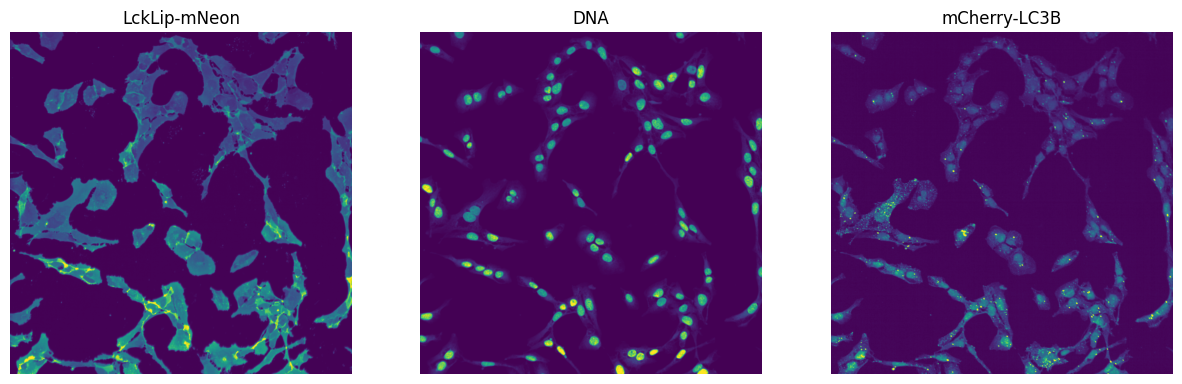

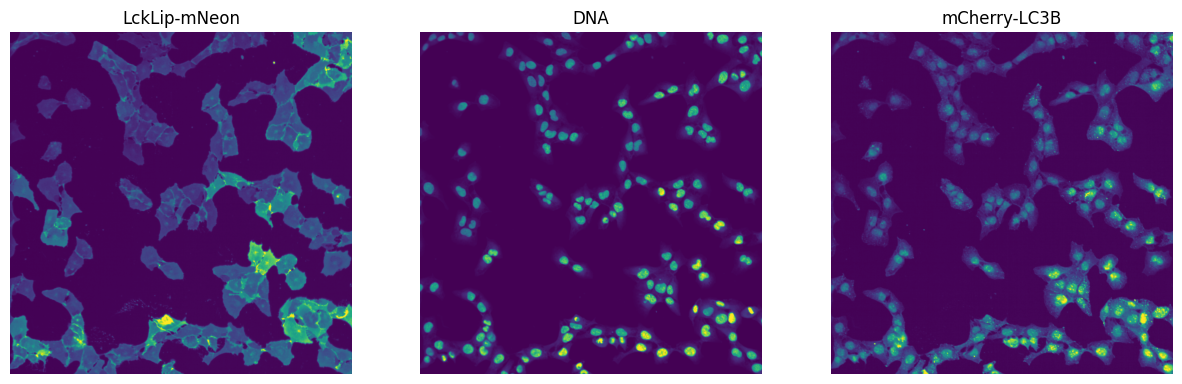

In [72]:
FOV_example_images = metadata_files.sort_values(by = ["cell_line_clone", "stimulation", "FOV"]).head(3).reset_index(drop=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, row in FOV_example_images.iterrows():
    print(row["image_path"])
    path = ln.Artifact.get(key = row["image_path"]).load().path
    image = imread(path)
    axs[idx].imshow(image)
    axs[idx].set_title(f'{row["imaged structure"]}')
    axs[idx].axis("off")

FOV_example_images = metadata_files.sort_values(by = ["cell_line_clone", "stimulation", "FOV"]).tail(3).reset_index(drop=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, row in FOV_example_images.iterrows():
    path = ln.Artifact.get(key = row["image_path"]).load().path
    image = imread(path)
    axs[idx].imshow(image)
    axs[idx].set_title(f'{row["imaged structure"]}')
    axs[idx].axis("off")

In [73]:
ln.finish()

• please hit CTRL + s to save the notebook in your editor .... still waiting . ✓
! cells [(1, 12), (12, 3), (3, 56), (56, None), (None, 64), (66, 69), (69, 71)] were not run consecutively
→ finished Run('u6S41BHO') after 49m at 2025-02-23 16:02:53 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/VBrMixbCU41a0000
→ to update your notebook from the CLI, run: lamin save /home/lukas/code/lamin-usecases/docs/imaging.ipynb
